In [1]:
# Initialisation(s)

import os, sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # Running in Google CoLab
    from google.colab import drive
    drive.mount('/content/gdrive/')
    global_prefix = '/content/gdrive/MyDrive/Colab Notebooks/Jupyter-Puzzles/python/rush-hour/'
    os.chdir(global_prefix)
else:
    # Not running in Google CoLab
    global_prefix = os.getcwd().replace('\\','/') + '/'

sys.path.append(f'{global_prefix}../outils')

%run ../outils/parcours.ipynb

# [Rush Hour](https://en.wikipedia.org/wiki/Rush_Hour_(puzzle))

On se propose d'utiliser l'algorithme A* pour trouver une solution optimale d'une donnée du jeu.

Dans un garage carré $6\times6$ une voiture $c$ de la classe $\texttt{Car}$ est définie par

$c\texttt{.is\_vertical}$ booléen,  
$c\texttt{.base}\in[0,5]$ le numéro de la colonne de $c$ si $c\texttt{.is\_vertical}$, de la ligne sinon,  
$c\texttt{.length}$ et $c\texttt{.color}$

In [3]:
dimension = 6

class Car():
    def __init__(self, is_vertical, base_pos, length, color):
        self.is_vertical = is_vertical
        self.base = base_pos # numéro de colonne si is_vertical, de ligne sinon
        self.length = length
        self.color = color

Un jeu est défini par un couple  (*cars*, *positions*) où

*cars* est un tuple de $n$ voitures et  
*positions* est un tuple de $n$ entiers tel que

*positions*[$i$] définit la position de la voiture $c=$ *cars*[$i$] :  
c'est le numéro de la ligne la plus basse de $c$ si $c\texttt{.is\_vertical}$, de la colonne la plus à gauche de $c$ sinon.

In [43]:
jeu1 = ((
    Car(False, 2, 2, "red"),
    Car(True, 0, 3, 'skyblue'),
    Car(False, 3, 3, 'aliceblue'),
    Car(False, 5, 2, "aquamarine"),
    Car(False, 0, 2, "plum"),
    Car(True,  1, 2, "paleturquoise"),
    Car(True,  2, 2, "honeydew"),
    Car(True,  2, 2, "cornsilk"),
    Car(True,  3, 2, "greenyellow"),
    Car(False, 5, 2, "lightyellow"),
    Car(True,  4, 2, "lightgrey"),
    Car(False, 4, 2, "lightpink"),
    Car(True,  5, 3, "lightblue")
),
(3,0,0,0,1,1,1,4,3,3,0,4,1))

jeu2 = ((
    Car(False, 2, 2, "red"),
    Car(False, 3, 2, 'skyblue'),
    Car(True, 1, 2, 'aliceblue'),
    Car(True, 2, 2, "aquamarine"),
    Car(True, 2, 2, "plum"),
    Car(False, 4, 2, "paleturquoise"),
    Car(False,  5, 2, "honeydew"),
    Car(False,  0, 3, "cornsilk"),
    Car(True,  3, 2, "greenyellow"),
    Car(False, 3, 2, "lightyellow"),
    Car(True,  5, 3, "lightgrey")
),
(0,0,4,0,2,2,2,3,1,3,2))

Une action sera définie par un couple $(i,j)$ où $i$ est le numéro d'une voiture $c$ et $j=$ *positions*[$i$] $\pm1$ selon que la voiture avance ou recule.

#### Affichage des voitures

In [44]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
 

# hint est (indice, startfinal)
def plot_cars(jeu, name = '', hint = None):
    
    matplotlib.rcParams['toolbar'] = 'None'
    fig = plt.figure(facecolor='w')
    ax = fig.add_subplot(111)
    ax.axis('off')
    ax.axis('equal')
    h = .04
    ax.add_patch(plt.Rectangle((-h,-h),6. + 3*h,6. + 2*h, lw = 2, ec = 'midnightblue', fc = 'white'))
    ax.add_patch(plt.Rectangle((5.,2.),1.2,1., lw = 0, fc = 'white'))

    cars, positions = jeu
    for i, car in enumerate(cars):
    #for car in cars:     
        x,y,width,height = \
            (car.base + h, positions[i] + h, 1. - 2*h, car.length - 2*h) if car.is_vertical else \
            (positions[i] + h, car.base + h, car.length - 2*h, 1. - 2*h)
        ax.add_patch(plt.Rectangle((x,y),width,height,ec = 'black', fc = car.color))
        if hint:
            j, startfin = hint
            if j == i:
                if car.is_vertical:
                    dx = 0
                    x = car.base + .5
                    if positions[i] < startfin:
                        dy = .5
                        y = positions[i] + car.length
                    else:
                        dy = -.5
                        y = positions[i]
                else:
                    dy = 0
                    y = car.base + .5
                    if positions[i] < startfin:
                        dx = .5
                        x = positions[i] + car.length
                    else:
                        dx = -.5
                        x = positions[i]
                ax.add_patch(plt.arrow(x,y,dx,dy,head_width = .2,head_length = .3,length_includes_head = True))
    ax.plot() 
    if name:
        plt.savefig(name)
        plt.close() # évite l'affichage

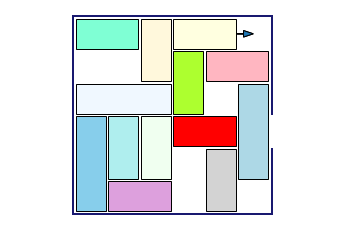

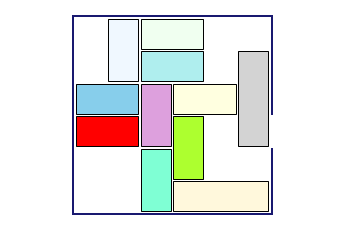

In [45]:
plot_cars(jeu1, hint = (9,4))
plot_cars(jeu2)

#### Calcul

On pourrait définir un état du jeu comme le $n$-tuple $p$ des positions des $n$ voitures mais, pour faciliter les calculs, un état sera le couple $(p,occ)$ où $occ$ est le tuple de tuples de booléens qui indique les cases occupées du garage.

In [46]:
import numpy as np

def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

def occOfPos(cars, pos):
    t = np.zeros((dimension, dimension), dtype = bool)
    for i, car in enumerate(cars):
        if car.is_vertical:
            for k in range(car.length):
                t[pos[i] + k, car.base] = True
        else:
            for k in range(car.length):
                t[car.base, pos[i] + k] = True
    return totuple(t)

def delta(cars, state, action):
    pos, occ = state
    i, posi = action
    lpos = list(pos)
    tocc = np.array(occ)
    car = cars[i]
    lpos[i] = posi
    if car.is_vertical:
        if posi > pos[i]: 
            tocc[pos[i] + car.length, car.base] = True
            tocc[pos[i], car.base] = False
        else:
            tocc[pos[i] + car.length - 1, car.base] = False
            tocc[pos[i] - 1, car.base] = True
    else:
        if posi > pos[i]: 
            tocc[car.base, pos[i] + car.length] = True
            tocc[car.base, pos[i]] = False
        else:
            tocc[car.base, pos[i] + car.length - 1] = False
            tocc[car.base, pos[i] - 1] = True
    return ((tuple(lpos), totuple(tocc)))


def solve(jeu):

    cars, positions = jeu

    start_state = (positions, occOfPos(cars, positions))

    def heuristic(state):
        return dimension - cars[0].length - state[0][0]

    def is_end_state(state):
        return heuristic(state) == 0

    # une action est un couple (indice, newstart)
    def legal_actions(state):
        pos, occ = state
        l = []
        for i, car in enumerate(cars):
            if car.is_vertical:
                if pos[i] + car.length < dimension and not occ[pos[i] + car.length][car.base]:
                    l.append((i, pos[i] + 1))
                if pos[i] >= 1  and not occ[pos[i] - 1][car.base]:
                    l.append((i, pos[i] - 1))
            else:
                if pos[i] + car.length < dimension and not occ[car.base][pos[i] + car.length]:
                    l.append((i, pos[i] + 1))
                if pos[i] >= 1  and not occ[car.base][pos[i] - 1]:
                    l.append((i, pos[i] - 1))
        return tuple(l)

    def d(state, action):
        return delta(cars, state, action)
        
    return aStar(start_state, is_end_state, legal_actions, d, heuristic = heuristic)

In [47]:
sol1 = solve(jeu1)

#### Affichage d'une solution par stockage sur disque des étapes de cette solution.

In [48]:
#! mkdir images

def write_sol(jeu, sol, prefix):
    """Stockage"""
    cars, positions = jeu
    prefix = f'{global_prefix}images/{prefix}-'
    state = (positions, occOfPos(cars, positions))
    for c, action in enumerate(sol):
        plot_cars((cars, state[0]), name = f'{prefix}{c}', hint = action)
        state = delta(cars,state,action)
    plot_cars((cars, state[0]), name = f'{prefix}{len(sol)}')

def display_sol(sol, prefix):
    import displayImages
    display_images = displayImages.mpl if IN_COLAB else displayImages.cv # displayImages.widgets marche mal (2 images ?)
    return display_images(f'{global_prefix}images/{prefix}-', len(sol))


In [49]:
write_sol(jeu1, sol1, "jeu1")

In [50]:
display_sol(sol1,'jeu1')

In [51]:
sol2 = solve(jeu2)
write_sol(jeu2, sol2, "jeu2")
display_sol(sol2,'jeu2')